# Trend Following Index Replication

This notebook will look at replicating the trend following returns index used by Societe Generale, which is what the authors do as well. 

# Packages, paths, and data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
fut_path    = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\FuturesData.parquet"
hf_path     = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\hf_indices.parquet"
ticker_path = r"A:\BBGFuturesManager_backup_backup\root\fut_tickers.xlsx"
spx_path    = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\spx.parquet"

In [3]:
df_px = (pd.read_parquet(
    path = fut_path, engine = "pyarrow").
    pivot(index = "date", columns = "security", values = "PX_LAST"))

df_ticker_guide = (pd.read_excel(
    io = ticker_path).
    assign(tmp = lambda x: 
           np.where(x.contract.str.len() == 1, x.contract + " 1", x.contract + "1") + " " + x.ending)
    [["tmp", "name", "kind"]].
    rename(columns = {
        "tmp" : "ticker",
        "kind": "Asset Class"}))

df_cta = (pd.read_parquet(
    path = hf_path, engine = "pyarrow").
    query("security == 'NEIXCTA Index'").
    set_index("date")
    [["PX_LAST"]].
    pct_change().
    dropna())

df_spx = (pd.read_parquet(
    path = spx_path, engine = "pyarrow").
    query("security == 'SPX Index'").
    rename(columns = {"PX_LAST": "SPX"}).
    set_index("date")
    [["SPX"]])

The following futures will be used

In [4]:
(df_ticker_guide.drop(
    columns = ["name"]).
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0] + " ").
    groupby("Asset Class").
    agg("sum").
    T)

Asset Class,Commodity,Currencies,Equity,Fixed Income
ticker,BO1 C CC1 CL1 CO1 CT1 GC1 HG1 HO1 KC1 LA1 LC1 ...,AD1 BP1 BTC1 CD1 EC1 JY1 NV1 PE1 SF1,CF1 ES1 GX1 HI1 NK1 NQ1 RTY1 UX1 VG1 Z,DU1 FF1 FV1 G JB1 OAT1 RX1 SER1 SFR1 TU1 TY1 U...


# Generating Single Trend Returns

In this case we are going to replicate the returns from the CTA index. They use a series of futures and currencies. Using this formulation

$\begin{align}
G_t :&= \sum_{k} G_{k,t}\\
    &= \sum_{k} \Pi_{k, t-1} D_{k,t} \\
    &= \lambda \tau \sum_{k} w_k \cdot \mathcal{L}_{\tau}\left(R_{k,t-1} \right) \cdot R_{k,t} 
\end{align}
$

The set a 1% volatility target on each individual strategy to make them uniform. The same is done here, except an additional portfolio volatility target of 5% is applied at the end, that is to match the returns of the index. To account for transaction a 0.2bps calculation for flipping the signal plus paying bid-ask is incorporated. 

In [5]:
df_signal = (df_px.diff().apply(
    lambda x: x / x.ewm(span = 10, adjust = False).std()).
    apply(lambda x: x.ewm(span = 180, adjust = False).mean()).
    shift().
    apply(lambda x: np.sign(x)))

In [6]:
df_signal_rtn = df_px.pct_change() * df_signal
df_weight     = (df_signal_rtn.apply(
    lambda x: 0.01 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252))))

In [7]:
df_tf = ((df_signal_rtn * df_weight).
    mean(axis = 1).
    to_frame(name = "rtn").
    apply(lambda x: x * (0.05 / (x.ewm(span = 100, adjust = False).std().shift() * np.sqrt(252)))))

In [8]:
df_tc = (df_signal.diff().apply(
    lambda x: x * (0.20 / 10_000)).
    apply(lambda x: -np.abs(x)).
    sum(axis = 1).
    to_frame(name = "tc"))

In [9]:
df_tmp = (df_tf.merge(
    right = df_tc, how = "inner", on = ['date']).
    assign(net_rtn = lambda x: x.rtn + x.tc)
    [["rtn", "net_rtn"]].
    rename(columns = {"rtn": "gross_rtn"}))

In [10]:
df_combined = (df_tmp.merge(
    right = df_cta, how = "inner", on = ["date"]))

Text(0.5, 0.98, 'Returns Comparison of Trend Following using 180d EWMA across all futures using 5% Ann. Volatily Targetting\nFrom 2000-01-03 to 2023-10-24')

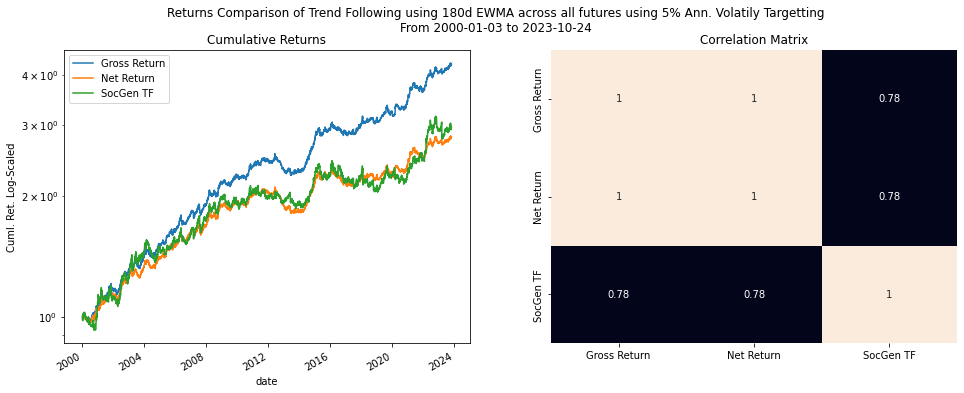

In [11]:
fig, axes = plt.subplots(ncols = 2, figsize = (16,6))

df_plot_combined = (df_combined.
    rename(columns = {
        "gross_rtn": "Gross Return",
        "net_rtn"  : "Net Return",
        "PX_LAST"  : "SocGen TF"}))

(df_plot_combined.apply(
    lambda x: np.cumprod(1 + x)).
    plot(
        logy   = True,
        legend = True,
        ylabel = "Cuml. Ret. Log-Scaled",
        ax     = axes[0],
        title  = "Cumulative Returns"))

sns.heatmap(
    data  = df_plot_combined.corr(),
    ax    = axes[1],
    cbar  = False,
    annot = True)

axes[1].set_title("Correlation Matrix")

fig.suptitle("Returns Comparison of Trend Following using 180d EWMA across all futures using 5% Ann. Volatily Targetting\nFrom {} to {}".format(
    df_plot_combined.index.min().date(),
    df_plot_combined.index.max().date()))

There is a slight problem when it comes to volatility targetting. The data is daily returns therefore the volatility targetting can't adjust the weighting for big intraday returns. Normally when volatility targetting the weight value is lagged since it's not possible to know the returns of the signal at time $t$ and its volatility. 

Below is a plot of volatility targetting and its correlation matrix for when weights aren't lagged. 

In [12]:
df_tf_tmp = ((df_signal_rtn * df_weight.shift()).
    mean(axis = 1).
    to_frame(name = "rtn").
    apply(lambda x: x * (0.05 / (x.ewm(span = 100, adjust = False).std().shift() * np.sqrt(252)))))

df_combined_tmp = (df_tf_tmp.merge(
    right = df_tc, how = "inner", on = ["date"]).
    assign(net_rtn = lambda x: x.rtn + x.tc).
    rename(columns = {"rtn": "gross_rtn"}).
    drop(columns = ["tc"]).
    dropna().
    merge(right = df_cta, how = "inner", on = ["date"]).
    rename(columns = {
        "gross_rtn": "Gross Return",
        "net_rtn"  : "Net Return",
        "PX_LAST"  : "SocGen TF"}))

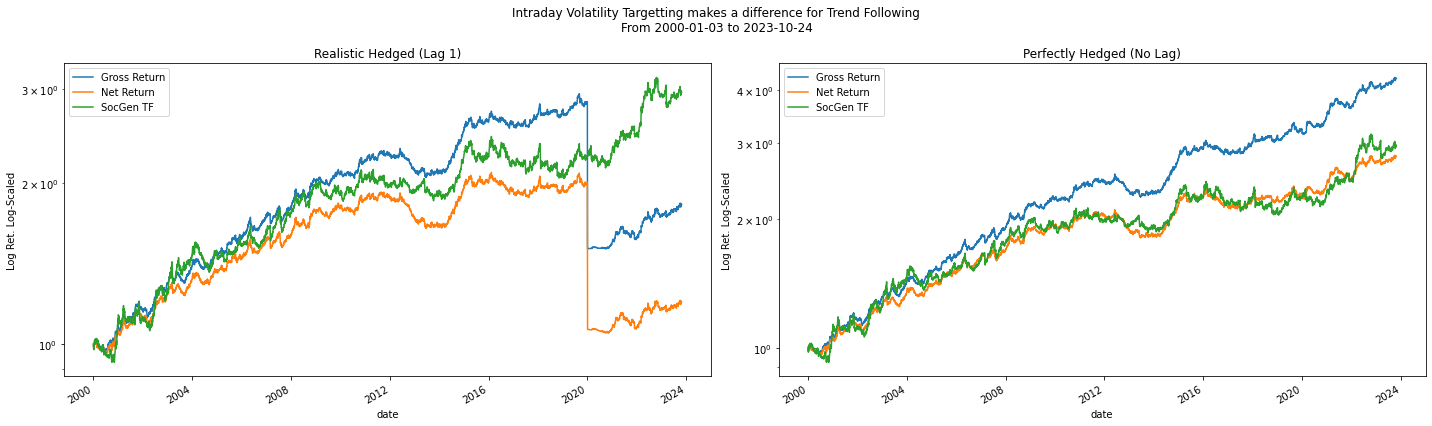

In [13]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_combined_tmp.apply(
    lambda x: np.cumprod(1 + x)).
    plot(
        logy   = True, 
        ax     = axes[0],
        ylabel = "Log Ret. Log-Scaled",
        title  = "Realistic Hedged (Lag 1)"))

(df_plot_combined.apply(
    lambda x: np.cumprod(1 + x)).
    plot(
        ylabel = "Log Ret. Log-Scaled",
        logy   = True,
        ax     = axes[1],
        title  = "Perfectly Hedged (No Lag)"))

fig.suptitle("Intraday Volatility Targetting makes a difference for Trend Following\nFrom {} to {}".format(
    df_combined_tmp.index.min().date(),
    df_combined_tmp.index.max().date()))

plt.tight_layout()

In [14]:
df_realistic_corr = (df_combined_tmp.corr()[
    ["Gross Return"]].
    reset_index().
    query("index == 'SocGen TF'").
    assign(hedging = "realistic"))

In [15]:
df_perfectly_corr = (df_combined.corr()[
    ["gross_rtn"]].
    reset_index().
    query("index == 'PX_LAST'").
    assign(hedging = "perfectly").
    rename(columns = {"gross_rtn": "Gross Return"}))

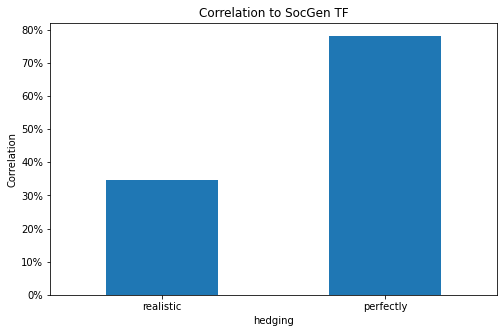

In [16]:
fig, axes = plt.subplots(figsize = (8,5))

(pd.concat([
    df_realistic_corr, df_perfectly_corr]).
    set_index("hedging")
    [["Gross Return"]].
    plot(
        ax      = axes,
        kind    = "bar",
        rot     = 0,
        legend  = False,
        ylabel  = "Correlation",
        title   = "Correlation to SocGen TF"))

axes.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{100*y:.0f}%"))

Although the returns aren't completely accurate the most likely scenario is that positions get adjusted intraday during big volatility moves. Since its not possible to hedge the returns intraday to avoid big swings which usually occur in STIR and refined energies it will be used since it has such as high correlation to the real returns. 

Therefore the rest of the analysis will use the perfectly hedged returns. 

# Analyzing the returns of the replicator

In [17]:
renamer = {
        "PX_LAST": "SocGen TF",
        "gross_rtn": "Gross Rtn",
        "net_rtn"  : "Net Rtn"}

df_spx_combined = (df_combined.merge(
    df_spx, how = "inner", on = ["date"]).
    rename(columns = renamer).
    reset_index().
    set_index(["date", "SPX"]).
    apply(lambda x: np.cumprod(1 + x) * 100).
    reset_index().
    set_index("date").
    resample("1M").
    last().
    pct_change().
    reset_index().
    melt(id_vars = ["date", "SPX"], value_name = "rtn").
    dropna())

Below is the regression for the Trend Returns against SPX returns which shows similar results for the beta exposure. 

In [18]:
def _single_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.rtn,
        exog  = sm.add_constant(df.SPX)).
        fit())
    
    df_out = (pd.DataFrame({
        "param"   : model.params,
        "p_values": model.pvalues,
        "t_values": model.tvalues}))
    
    return df_out

(df_spx_combined.groupby(
    "variable").
    apply(_single_ols).
    apply(lambda x: np.round(x,4)))

param  p_values  t_values
variable                                   
Gross Rtn const  0.0052    0.0000    5.6682
          SPX   -0.0694    0.0009   -3.3615
Net Rtn   const  0.0038    0.0001    4.0940
          SPX   -0.0710    0.0008   -3.4057
SocGen TF const  0.0039    0.0095    2.6107
          SPX   -0.0532    0.1137   -1.5869

In [19]:
(df_combined.merge(
    df_spx, how = "inner", on = ["date"]).
    reset_index().
    set_index(["date", "SPX"]).
    apply(lambda x: np.cumprod(1 + x) * 100).
    reset_index().
    set_index("date").
    resample("1M").
    last().
    pct_change().
    assign(SPX = lambda x: x.SPX ** 2).
    rename(columns = renamer).
    reset_index().
    melt(id_vars = ["date", "SPX"], value_name = "rtn").
    dropna().
    groupby("variable").
    apply(_single_ols).
    apply(lambda x: np.round(x,4)))

param  p_values  t_values
variable                                   
Gross Rtn const  0.0030    0.0062    2.7560
          SPX    0.9571    0.0010    3.3267
Net Rtn   const  0.0015    0.1730    1.3661
          SPX    0.9902    0.0007    3.4106
SocGen TF const  0.0027    0.1198    1.5604
          SPX    0.4533    0.3344    0.9669

In [20]:
def _get_two_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.value,
        exog  = sm.add_constant(df[["SPX", "SPX2"]])).
        fit())
    
    df_out = (pd.DataFrame({
        "params"  : model.params,
        "p_values": model.pvalues,
        "t_values": model.tvalues}))
    
    return df_out

(df_spx_combined.pivot(
    index = ["date", "SPX"], columns = "variable", values = "rtn").
    reset_index().
    assign(SPX2 = lambda x: x.SPX ** 2).
    melt(id_vars = ["date", "SPX", "SPX2"]).
    groupby("variable").
    apply(_get_two_ols).
    apply(lambda x: np.round(x,4)))

params  p_values  t_values
variable                                   
Gross Rtn const  0.0035    0.0012    3.2672
          SPX   -0.0597    0.0042   -2.8895
          SPX2   0.8205    0.0047    2.8494
Net Rtn   const  0.0021    0.0599    1.8891
          SPX   -0.0609    0.0037   -2.9233
          SPX2   0.8508    0.0037    2.9288
SocGen TF const  0.0032    0.0731    1.7987
          SPX   -0.0492    0.1493   -1.4460
          SPX2   0.3407    0.4732    0.7182

The trend follower replicator generate similar results in terms of convexity to the SocGen Trend Following index in general. 

# Breaking Out by Asset Class

Because of the trend follower replicator index achieves a reasonable correlation to the index we can ascertain per each asset class.

In [21]:
df_tf_longer = ((df_signal_rtn * df_weight.shift()).reset_index().melt(
    id_vars = "date", var_name = "ticker", value_name = "rtn").
    dropna())

In [22]:
df_asset_tf = (df_tf_longer.merge(
    right = df_ticker_guide, how = "inner", on = ["ticker"])
    [["date", "rtn", "Asset Class"]].
    groupby(["date", "Asset Class"]).
    agg("mean").
    reset_index().
    pivot(index = "date", columns = "Asset Class", values = "rtn"))

The lagged hedging shows that huge intraday swings in fixed income which are likely from intraday swings in STIR futures not getting hedged during the day.

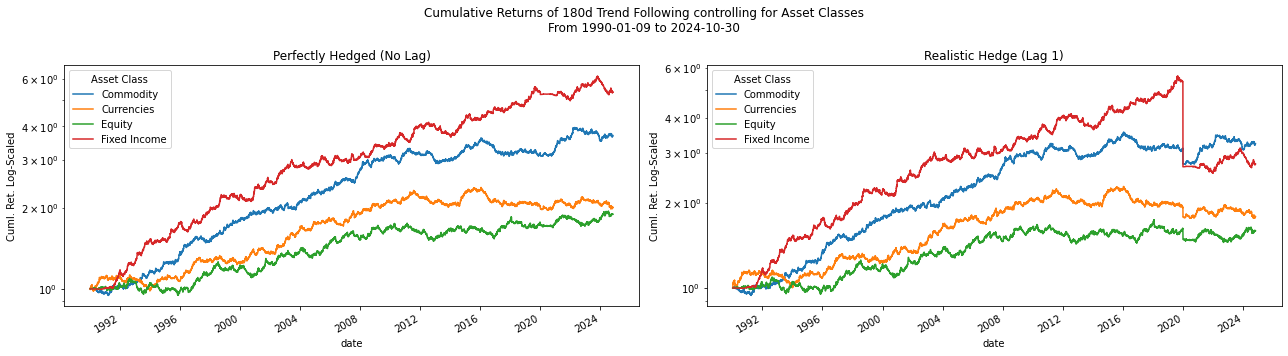

In [23]:
fig, axes = plt.subplots(ncols = 2, figsize = (18,5))

(df_asset_tf.apply(
    lambda x: x * (0.05 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    apply(lambda x: np.cumprod(1 + x)).
    plot(
        logy  = True,
        ax    = axes[0],
        title = "Perfectly Hedged (No Lag)"))

(df_asset_tf.apply(
    lambda x: x * (0.05 / (x.ewm(span = 100, adjust = False).std().shift() * np.sqrt(252)))).
    apply(lambda x: np.cumprod(1 + x)).
    plot(
        logy  = True,
        ax    = axes[1],
        title = "Realistic Hedge (Lag 1)"))

for ax in axes.flatten(): ax.set_ylabel("Cuml. Ret. Log-Scaled")
fig.suptitle("Cumulative Returns of 180d Trend Following controlling for Asset Classes\nFrom {} to {}".format(
    df_asset_tf.index.min().date(),
    df_asset_tf.index.max().date()))

plt.tight_layout()

# Two Window Trend

The authors use a two window trend specifically the 180d and 90d EWMA. Unfortunately I can't back out returns that have a high correlation to the returns. 

In [24]:
df_two_signal = (df_px.diff().apply(
    lambda x: x / x.ewm(span = 10, adjust = False).std()).
    apply(lambda x: x.ewm(span = 90, adjust = False).mean() -  x.ewm(span = 180, adjust = False).mean()).
    shift().
    apply(lambda x: np.sign(x)))

In [25]:
df_two_gross = ((df_px.pct_change() * df_two_signal).apply(
    lambda x: x * (0.01 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    mean(axis = 1).
    to_frame(name = "rtn").
    apply(lambda x: x * (0.10 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    rename(columns = {"rtn": "gross_rtn"}))

In [26]:
df_two_tc = (df_two_signal.diff().apply(
    lambda x: x * (0.02 / 10_000)).
    apply(lambda x: -np.abs(x)).
    sum(axis = 1).
    to_frame(name = "tc"))

In [27]:
df_two_combined = (df_two_gross.merge(
    right = df_two_tc, how = "inner", on = ["date"]).
    assign(net_rtn = lambda x: x.gross_rtn + x.tc).
    drop(columns = ["tc"]).
    dropna().
    merge(right = df_cta, how = "inner", on = ["date"]))

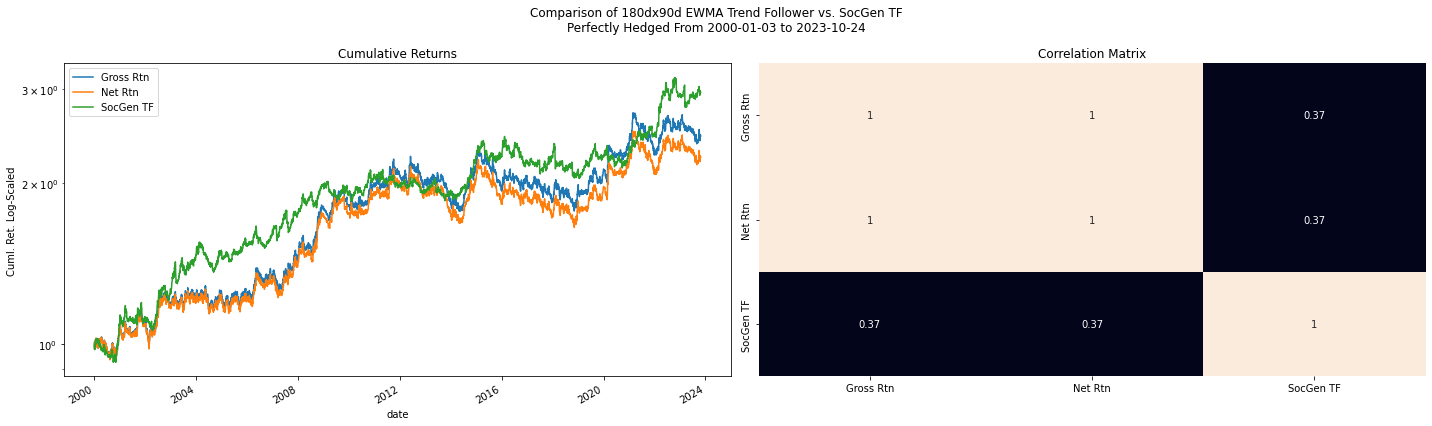

In [28]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_two_combined.apply(
    lambda x: np.cumprod(1 + x)).
    rename(columns = renamer).
    plot(
        logy   = True,
        ax     = axes[0],
        ylabel = "Cuml. Ret. Log-Scaled",
        title  = "Cumulative Returns"))

sns.heatmap(
    ax    = axes[1],
    data  = df_two_combined.rename(columns = renamer).corr(),
    annot = True,
    cbar  = False)

axes[1].set_title("Correlation Matrix")
fig.suptitle("Comparison of 180dx90d EWMA Trend Follower vs. SocGen TF\nPerfectly Hedged From {} to {}".format(
    df_two_combined.index.min().date(),
    df_two_combined.index.max().date()))

plt.tight_layout()